In [1]:
from __future__ import annotations
from typing import Optional, Tuple
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import seaborn as sns
import numpy as np

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

**Load data**

In [2]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEERPLUS_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')

In [3]:

from util_funcs import do_basic_filtering
from util_funcs import remove_identical_primary_secondary_cases

print('\nFiltering')
df = do_basic_filtering(master)
df = remove_identical_primary_secondary_cases(df)

from util_funcs import do_basic_formatting
from util_funcs import format_regional_nodes_bins
from util_funcs import format_ln_status

HISTTYPES_PATH = '/home/grace/work/SEER/data/histology/histcodes.tsv'
print('\nFormatting')
df = do_basic_formatting(df, HISTTYPES_PATH)
df = format_regional_nodes_bins(df)
df = format_ln_status(df)
df['ln_status'].value_counts(dropna=False)

df.head()


Filtering
Removing records not in range (2010, 2020)
- removed 371509 records
Selecting records with MALIGNANT behavior
- removed 632160 records
Handling patients with multiple records of same cancer_type
- removed 82397 records

Final records: 4518517, patients: 4238366
Removing MET records where primary tissue is identical to secondary tissue
- removed 69806 records

Formatting
Missing 0 codes.
Formatting cancer subtypes
TNG, Grade standardisation
formatting regional nodes derived fields
formatting ln_status


,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,regional_nodes_examined,regional_nodes_positive,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,other_met,distant_ln,any_met,hist_type_descr,TSTAGE_STD,NSTAGE_STD,GSTAGE_STD,GRADE_STD,regional_nodes_prop,regnodes_exam_bin,regnodes_pos_bin,regnodes_prop_bin,ln_status
4,139,"2,011.00",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,3.00,0.00,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NaN,NaN,NO,Infiltrating duct carcinoma [+ others],T3,N0,II,G3,0.00,"(0, 10]","(0, 10]","(0.00, 0.25]",NaN
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,3.00,0.00,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,False,NO,Infiltrating duct carcinoma [+ others],T2,N0,II,G3,0.00,"(0, 10]","(0, 10]","(0.00, 0.25]",negative
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,10.00,0.00,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,NO,False,NO,Serous carcinoma [+ others],T1,N0,I,G2,0.00,"(0, 10]","(0, 10]","(0.00, 0.25]",negative
7,220,NaN,2011,2020,70-74 years,Prostate,Prostate,Prostate,Prostate,T1c,N0,II,NaN,NaN,NaN,G2,NaN,NaN,0.00,NaN,MALIGNANT,2,0,6.60,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NaN,NO,Adenoma [+ others],T1,N0,II,G2,NaN,"(0, 10]",NaN,NaN,NaN
8,265,"2,016.00",2011,2016,65-69 years,Prostate,Prostate,Prostate,Prostate,T2c,N0,II,NaN,NaN,NaN,G3,NaN,NaN,0.00,NaN,MALIGNANT,2,0,7.70,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NaN,NO,Adenoma [+ others],T2,N0,II,G3,NaN,"(0, 10]",NaN,NaN,NaN


In [4]:

FIELD_BRAIN_PREFERENCE = 'p( BRAIN MET | ANY MET )'
FIELD_NUM_RECORDS = 'NUM RECORDS'

# BRAIN_PREFERENCE_MEASURE = 'BRAIN PREFERENCE MEASURE'
def calculate_met_rates(pred: str, df: pd.DataFrame) -> Tuple:
        
    # df for raw case counts
    counts = pd.DataFrame()

    METS = ['brain_met', 'bone_met', 'lung_met', 'liver_met', 'any_met']
    for met in METS:
        yn_df = df.groupby(by=[pred, met]).size().unstack(fill_value=0)
        if 'YES' not in yn_df.columns:
            yn_df['YES'] = 0
        if 'NO' not in yn_df.columns:
            yn_df['NO'] = 0
        counts[met + '_NO'] = yn_df['NO']
        counts[met + '_YES'] = yn_df['YES']

    df[(df['brain_met']=='YES') & (df['brain_met']=='YES')]
    # df for prevalence
    prevs = pd.DataFrame()
    for res in METS:
        prevs[res] = counts[res + '_YES'] / (counts[res + '_NO'] + counts[res + '_YES'])

    return counts, prevs

def run_met_rates(
    df: pd.DataFrame,
    pred: str, 
    min_observations: int=1000,
    metric: str='prevalence'
    ) -> pd.DataFrame:
    assert metric in ['prevalence', 'condprob']

    if metric == 'condprob':
        df = df[df['any_met']=='YES']
    
    df = df.groupby(pred).filter(lambda x : len(x) >= min_observations)

    counts, prevs = calculate_met_rates(pred, df)
    METS = ['brain_met', 'bone_met', 'lung_met', 'liver_met', 'any_met']
    summ = prevs[METS]
    summ[FIELD_NUM_RECORDS] = counts['any_met_NO'] + counts['any_met_YES']

    # prevalence to percent % 
    if metric == 'prevalence':
        for field in METS:
            summ[field] = prevs[field] * 100
            
    return summ


In [5]:
import os 

def plot_condprob_heatmap(
    df: pd.DataFrame,
    groups: list[str],
    subdir_override: Optional[str]=None,
    ) -> None:
    LARGE_VALUE = 100000000000000
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 150)
    pd.options.display.float_format = "{:,.2f}".format
        
    MAX_ROWS = 200
    rowcount = df.shape[0]
    if rowcount > MAX_ROWS:
        print('Num rows exceeds MAX_ROWS!!')
    df = df.head(MAX_ROWS)
    df = df.sort_values(by='any_met', ascending=False)
    condprobs = df.drop([FIELD_NUM_RECORDS], axis=1)
    cases1D = df[[FIELD_NUM_RECORDS]]
    
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, (rowcount//2)+4), gridspec_kw={'width_ratios':[5,1]}, layout="compressed")
    a1 = axs[0].matshow(condprobs, cmap='rocket_r', vmax=2)
    axs[1].matshow(cases1D, cmap='binary', vmax=LARGE_VALUE)

    flat_axes = axs.flat
    flat_data = [condprobs, cases1D]
    for i, (ax, data) in enumerate(zip(flat_axes, flat_data)):
        data_matrix = data.T.to_numpy()
        for (x, y), value in np.ndenumerate(data_matrix):
            if i % 2 == 1:
                ax.text(x-0.5, y, f"{value}", va="center", ha="left")
            else:
                ax.text(x, y, f"{value:.1f}", va="center", ha="center")
        
        # first col: add y ticks
        if i % 4 == 0:
            ytick_marks = np.arange(len(data.index))
            ax.set_yticks(ytick_marks, data.index)
            # ax.set_ylabel(data.index.name)
        else:
            ax.set_yticks([])
        
        # first row: add x ticks
        xtick_marks = np.arange(len(data.columns))
        ax.set_xticks(xtick_marks, data.columns, rotation=90)

        # third row: remove frame 
        if i % 4 == 1:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.tick_params(left = False, top = False, bottom = False)
    
    # titles & saving
    group_lab = ':'.join(groups)
    title = f'{group_lab}'
    plt.suptitle(title, y=1.03, fontsize='x-large')
    title_fmtd = title.strip()
    title_fmtd = title_fmtd.split(' vs ')[0]
    title_fmtd = title_fmtd.replace('_', '')
    title_fmtd = title_fmtd.replace(': ', '_')
    title_fmtd = title_fmtd.lower()

    if subdir_override:
        filepath = f'/home/grace/work/SEER/outputs/heatmaps/condprob/{subdir_override}/{group_lab}.png'
    else:
        filepath = f'/home/grace/work/SEER/outputs/heatmaps/condprob/{group_lab}.png'
    os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
    plt.savefig(filepath)
    print(filepath)


In [ ]:
import os 

def plot_prevalence_heatmaps(
    df: pd.DataFrame,
    cases: pd.DataFrame,
    groups: list[str],
    subdir_override: Optional[str]=None,
    ) -> None:
    LARGE_VALUE = 100000000000000
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 150)
    pd.options.display.float_format = "{:,.2f}".format
    sns.set_style("white")

    MAX_ROWS = 200
    rowcount = df.shape[0]
    if rowcount > MAX_ROWS:
        print('Num rows exceeds MAX_ROWS!!')
    df = df.head(MAX_ROWS)

    SORTCOLS = ['any_met', 'brain_met', FIELD_BRAIN_PREFERENCE]
    LABELS = ['anyrate', 'brainrate', 'braintend']
    for sortcol, label in zip(SORTCOLS, LABELS):
        offset = 0.5

        # sorting
        df = df.sort_values(by=sortcol, ascending=False)
        cases = cases.loc[df.index.to_list()]
        assert cases.index.to_list() == df.index.to_list()

        freqs = df.drop([FIELD_NUM_RECORDS, FIELD_NUM_RECORDS + '(met)', FIELD_BRAIN_PREFERENCE], axis=1)
        basecases1D = df[[FIELD_NUM_RECORDS]]
        tend1D = df[[FIELD_BRAIN_PREFERENCE]]
        
        lwidth = max([len(x) for x in df.index.to_list()]) / 20
        fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(8 + lwidth + 1, (rowcount//2)+4), width_ratios=[5 + lwidth,1,1,1])
        sns.heatmap(freqs, annot=False, cmap='rocket_r', vmax=90, cbar=False, ax=axs[0])
        sns.heatmap(tend1D, annot=False, cmap='PiYG_r', vmin=-0.3, cbar=False, vmax=0.4, ax=axs[1])
        sns.heatmap(cases, annot=False, cmap='Blues', cbar=False, ax=axs[2])
        sns.heatmap(basecases1D, annot=False, cmap='binary', cbar=False, vmax=LARGE_VALUE, ax=axs[3])
        # fig.colorbar(ax.get_children()[0], cax=cax, orientation="horizontal")

        metlabels = [x.replace('_met', '') for x in freqs.columns.to_list()]

        # titles
        axs[0].set_title('Prevalence')

        # labels 
        for ax in axs.flat:
            ax.set_ylabel('')
            ax.set_xlabel('')

        # # yticks
        for ax in axs.flat[1:]:
            ax.set_yticks([])
            ax.set_yticklabels([])
        # ytick_marks = [y-0.5 for y in range(len(freqs.index))]
        # axs[0].set_yticks(ytick_marks, freqs.index)

        # xticks
        for ax in axs.flat:
            ax.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
        axs[0].set_xticks([x-offset for x in [1, 2, 3, 4, 5]])
        axs[1].set_xticks([1-offset])
        axs[2].set_xticks([1+1])
        axs[3].set_xticks([1-offset])
        axs[0].set_xticklabels(metlabels, rotation=90)
        axs[1].set_xticklabels(['p( brain_met | any_met )'], rotation=90)
        axs[2].set_xticklabels(['Metastasis Case Load'], rotation=90)
        axs[3].set_xticklabels(['Total Case Load'], rotation=90)
        
        # spines
        axs[2].spines['top'].set_visible(True)
        axs[2].spines['right'].set_visible(True)
        axs[2].spines['bottom'].set_visible(True)
        axs[2].spines['left'].set_visible(True)

        axs[3].spines['top'].set_visible(False)
        axs[3].spines['right'].set_visible(False)
        axs[3].spines['bottom'].set_visible(False)
        axs[3].spines['left'].set_visible(False)

        # text
        flat_data = [freqs, tend1D, cases, basecases1D]
        for i, (ax, data) in enumerate(zip(axs.flat, flat_data)):
            data_matrix = data.T.to_numpy()
            
            for (x, y), value in np.ndenumerate(data_matrix):
                if i % 4 == 3:
                    ax.text(x+offset, y+offset, f"{value}", va="center", ha="center")
                elif i % 4 == 1:
                    ax.text(x+offset, y+offset, f"{value:.2f}", va="center", ha="center")
                elif i % 4 == 2:
                    pass 
                else:
                    ax.text(x+offset, y+offset, f"{value:.1f}", va="center", ha="center")
        
        # titles & saving
        group_lab = ':'.join(groups)
        title = f'{group_lab}'
        plt.suptitle(title, y=1.03, fontsize='x-large')
        title_fmtd = title.strip()
        title_fmtd = title_fmtd.split(' vs ')[0]
        title_fmtd = title_fmtd.replace('_', '')
        title_fmtd = title_fmtd.replace(': ', '_')
        title_fmtd = title_fmtd.lower()

        if subdir_override:
            filepath = f'/home/grace/work/SEER/outputs/heatmaps/prevalence/{subdir_override}/{group_lab}_{label}.png'
        else:
            filepath = f'/home/grace/work/SEER/outputs/heatmaps/prevalence/{group_lab}/{label}.png'
        os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
        plt.tight_layout()
        plt.savefig(filepath)
        plt.show()
        print(filepath)


                                brain_met  bone_met  lung_met  liver_met  any_met  NUM RECORDS  p( BRAIN MET | ANY MET )  NUM RECORDS(met)
group                                                                                                                                     
Anus, Anal Canal and Anorectum       0.12      1.10      2.22       3.82     5.81        19689                      0.02          1,143.00
Appendix (carcinoid)                 0.02      0.10      0.08       0.50     2.11         6251                       NaN               NaN
Appendix (carcinoma)                 0.04      0.81      1.40       5.48    21.13         7356                      0.00          1,554.00
Bones and Joints                     0.30      0.00      9.66       0.60     9.73         8687                       NaN               NaN
Brain                                0.00      0.14      0.09       0.04     0.43        58422                       NaN               NaN


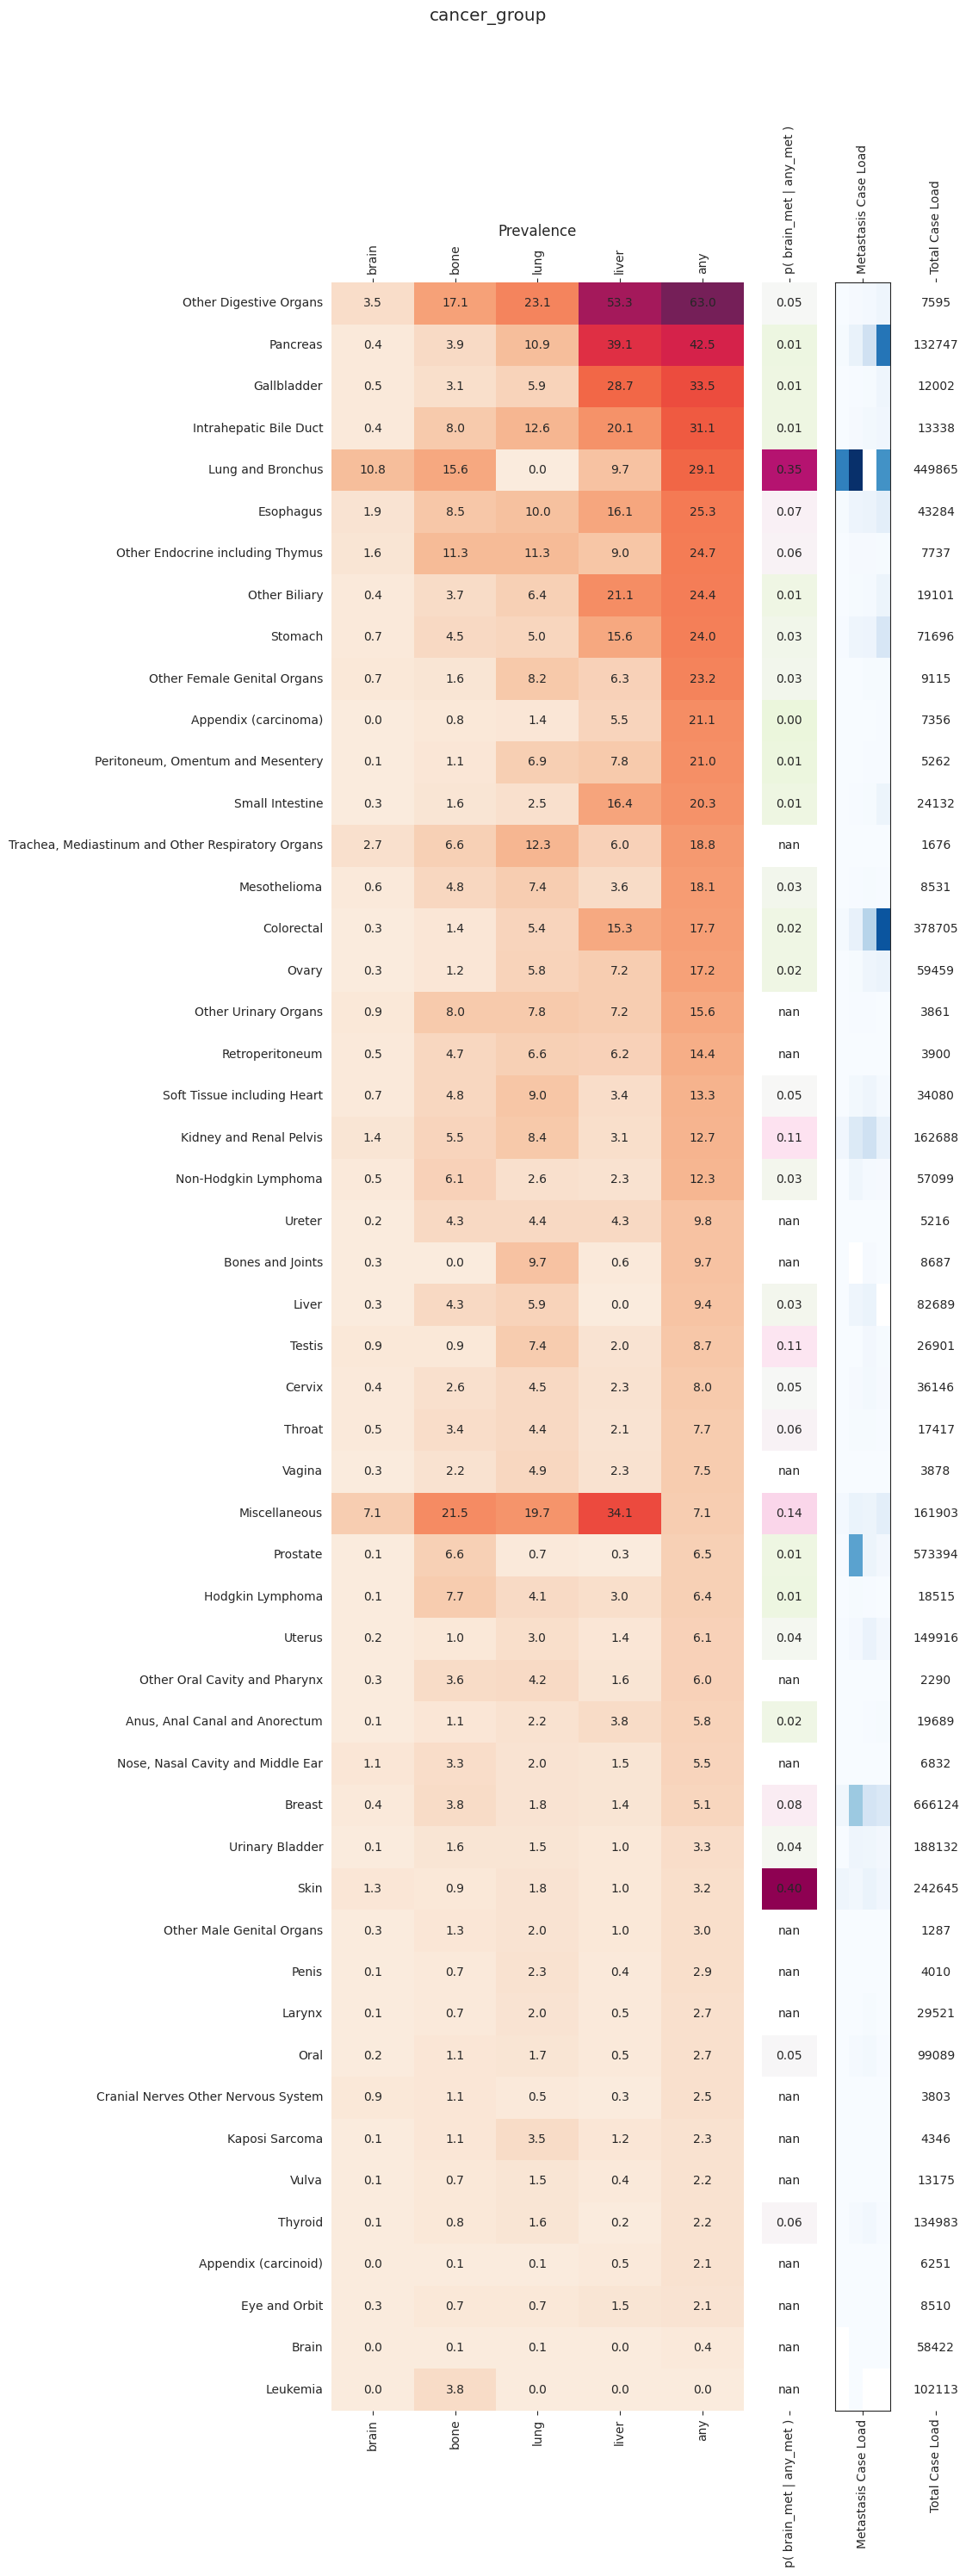

/home/grace/work/SEER/outputs/heatmaps/prevalence/cancer_group/anyrate.png


<Figure size 640x480 with 0 Axes>

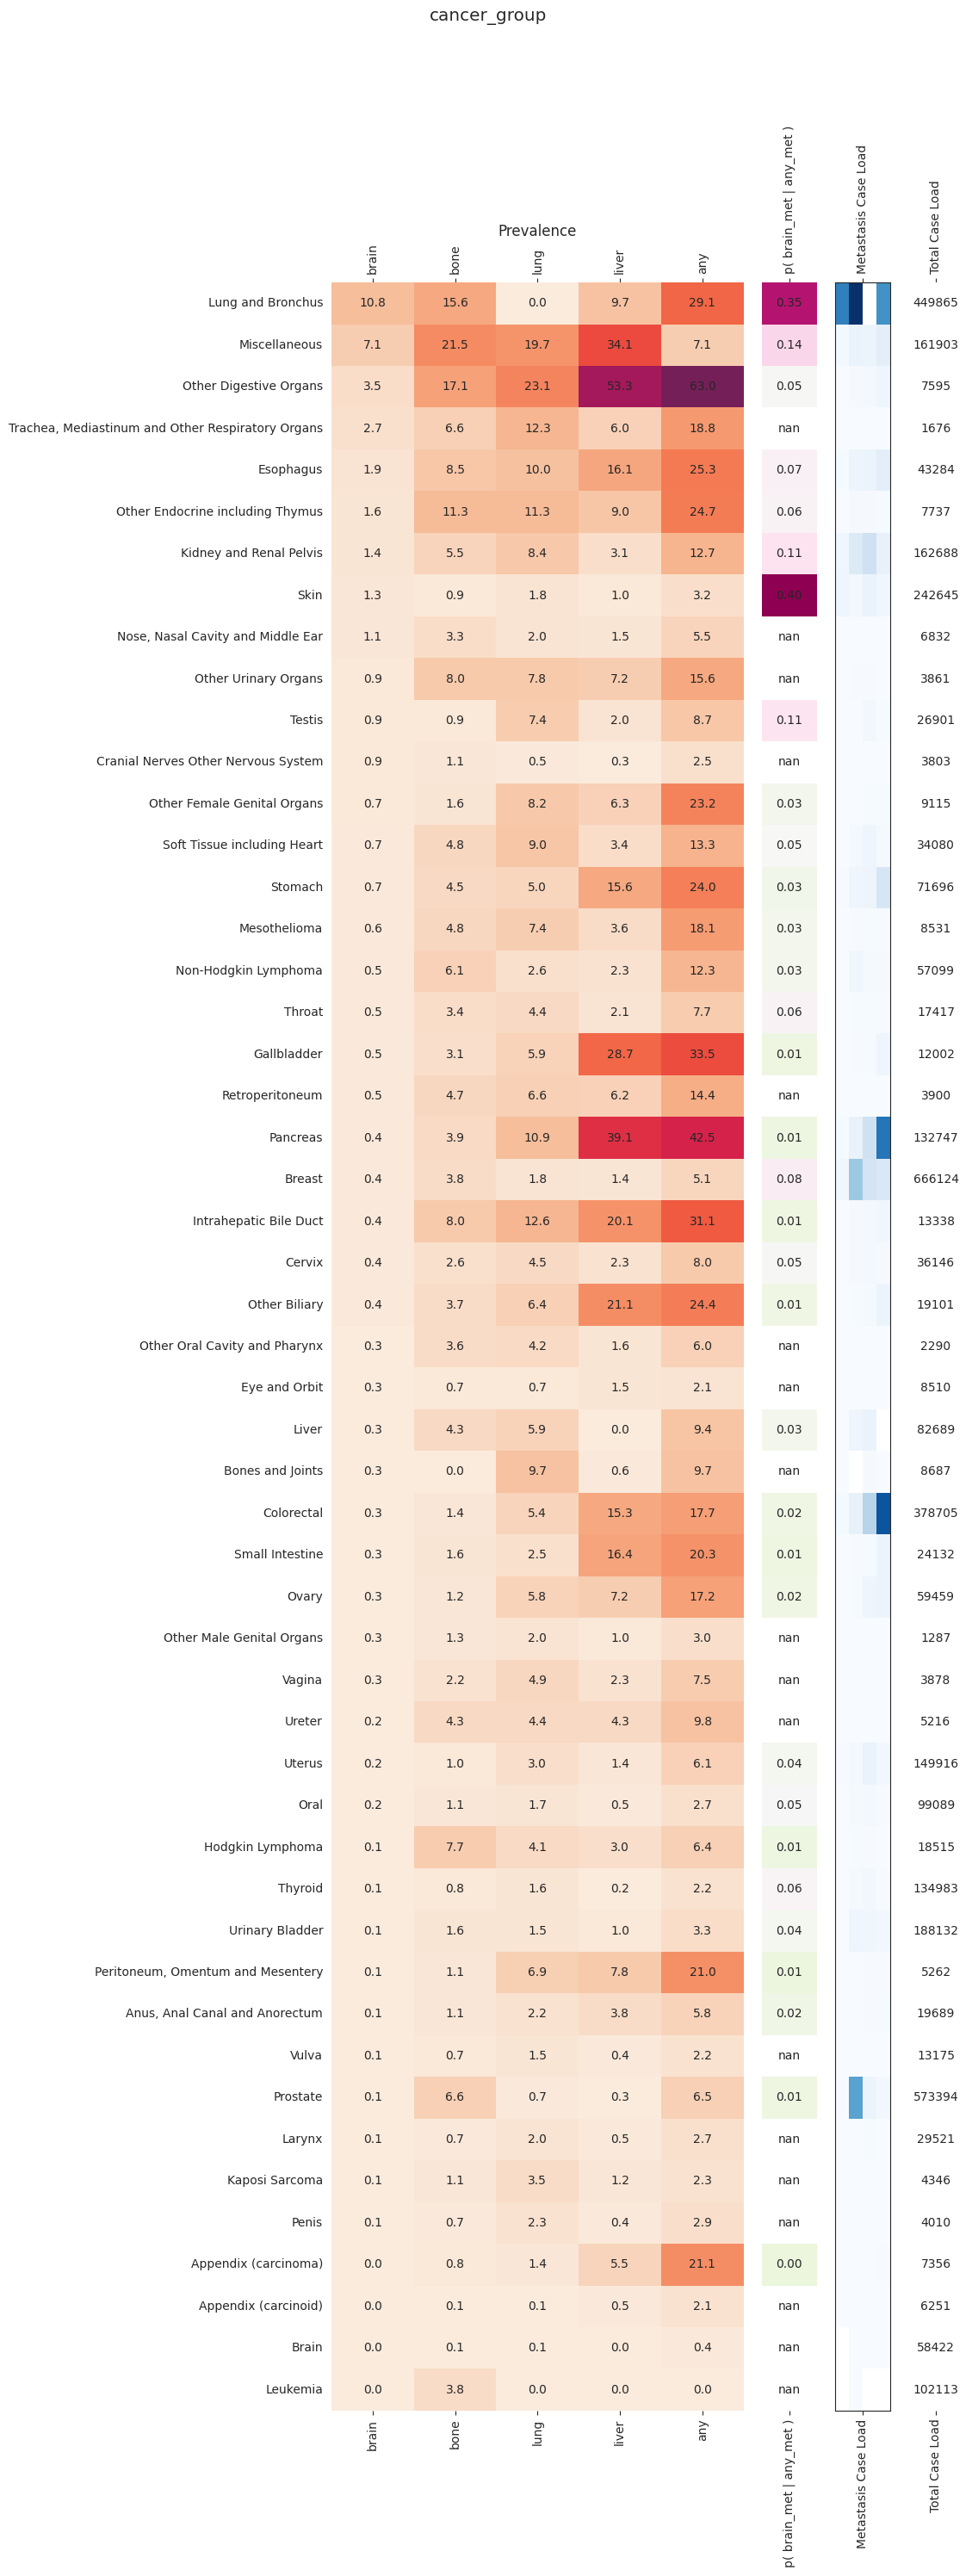

/home/grace/work/SEER/outputs/heatmaps/prevalence/cancer_group/brainrate.png


<Figure size 640x480 with 0 Axes>

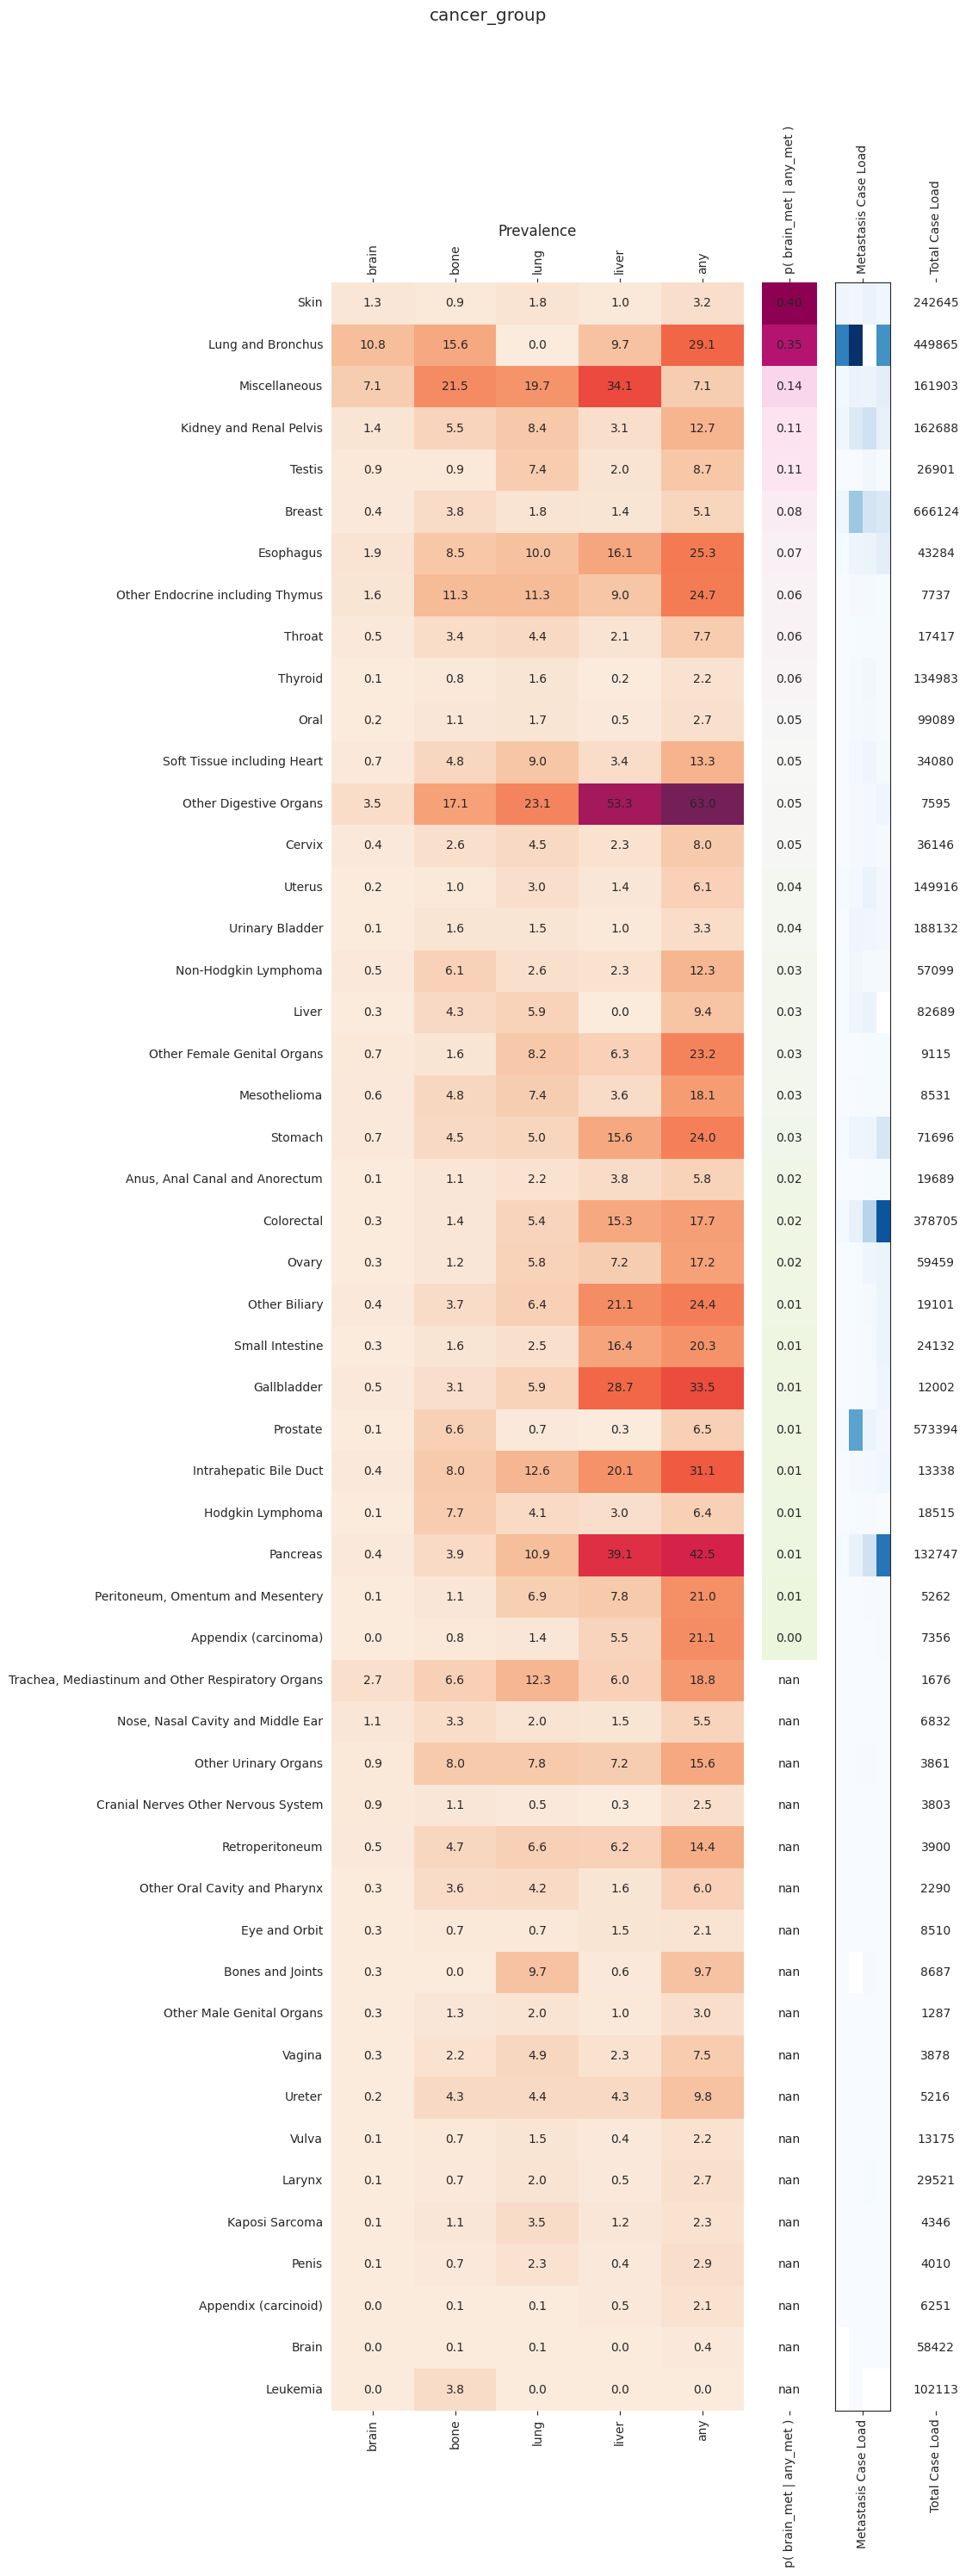

/home/grace/work/SEER/outputs/heatmaps/prevalence/cancer_group/braintend.png


<Figure size 640x480 with 0 Axes>

In [11]:
MIN_FEATURE_OBSERVATIONS = 1000
RESPONSES = ['brain_met', 'bone_met', 'lung_met', 'liver_met']

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

def run_heatmaps(
    groups: list[str], 
    df: pd.DataFrame, 
    group_subsets: Optional[dict[str, list[str]]]=None, 
    subdir_override: Optional[str]=None
    ) -> None:
    COMPOUND_GROUP = 'group'

    # subset filtering 
    temp = df
    if group_subsets is not None:
        for field, vlist in group_subsets.items():
            temp = temp.loc[temp[field].isin(vlist)]

    # removing missing values
    temp = temp.dropna(subset=groups)

    # create compound group if more than 1 'group'
    if len(groups) == 1:
        temp[COMPOUND_GROUP] = temp[groups[0]]
    else:
        temp[COMPOUND_GROUP] = temp[groups].agg(':'.join, axis=1)

    maintable = run_met_rates(df=temp, pred=COMPOUND_GROUP, metric='prevalence')
    mettable = run_met_rates(df=temp[temp['any_met']=='YES'], pred=COMPOUND_GROUP, metric='condprob')
    maintable[FIELD_BRAIN_PREFERENCE] = mettable['brain_met']
    maintable[FIELD_NUM_RECORDS + '(met)'] = mettable[FIELD_NUM_RECORDS]
    print(maintable.head())

    casetable = pd.DataFrame(data=0, index=maintable.index, columns=RESPONSES)
    for res in RESPONSES:
        counts = temp[temp[res]=='YES'].groupby(by=[COMPOUND_GROUP]).size()
        casetable[res] = counts
        
    plot_prevalence_heatmaps(maintable, casetable, groups=groups, subdir_override=subdir_override)

run_heatmaps(groups=['cancer_group'], df=df)
# run_heatmaps(groups=['hist_cateogry'], df=df)
# run_heatmaps(groups=['hist_type_descr'], df=df)
# run_heatmaps(groups=['cancer_group', 'hist_cateogry'], df=df)
# run_heatmaps(groups=['TSTAGE_STD'], df=df)

# subdir_override

In [8]:
plot_condprob_heatmap(mettable, groups=['cancer_group'])

NameError: name 'mettable' is not defined

**Addressing tumors where 'site recode' is mismatch to 'primary site'**

For patients with single record, these only occur when 'site recode' is a cancer_type of nebulous location. <br>
Specifically, Lymphomas. 

Necessary because SEER 'site recode' and 'primary site' mean different things. 

site recode (cancer_type)
- cancer type rather than 'site' (eg Hodgkin Lymphoma)

primary site (primary_type)
- location of primary tumor. 
- organ (eg lung), or region (eg Bones and Joints) 
- in the case of Hodgkin Lymphoma etc, primary site could be any general location as lymph nodes are spread around the body. 
    

aslkdj
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [ ]:
singles_df = master.drop_duplicates(subset=['patient_id'], keep=False)
multiples_df = master[master.duplicated(subset=['patient_id'], keep=False)]

In [ ]:
singles_df = master.drop_duplicates(subset=['patient_id'], keep=False)
multiples_df = master[master.duplicated(subset=['patient_id'], keep=False)]

In [ ]:
singles_df = master.drop_duplicates(subset=['patient_id'], keep=False)
singles_df = singles_df.loc[singles_df['cancer_type'] != 'Brain']
multiples_df = master[master.duplicated(subset=['patient_id'], keep=False)]
master.head()

In [ ]:
def override_primary_types(df: pd.DataFrame) -> pd.DataFrame:
    # if unsure between melanoma & non-melanoma, non-melanoma more common so guess this label.
    df.loc[df['primary_type']=='Melanoma of the Skin | Other Non-Epithelial Skin', 'primary_type'] = 'Other Non-Epithelial Skin'

    # override primary_type for cancer_types where the primary tumor can appear in variable locations in the body. 
    for ctype in [
        'NHL - Extranodal',
        'Mesothelioma',
        'Kaposi Sarcoma',
        'Myeloma',
        'Hodgkin - Extranodal',
        'Other Myeloid/Monocytic Leukemia',
    ]:
        # print()
        # print(df.loc[(df['cancer_type']!=df['primary_type']) & (df['cancer_type']==ctype)].head())
        # print()
        df.loc[(df['cancer_type']!=df['primary_type']) & (df['cancer_type']==ctype), 'primary_type'] = ctype
    return df

def summarise_mismatches(df: pd.DataFrame) -> None:
    mm_df = df[df['cancer_type'] != df['primary_type']][['cancer_type', 'primary_type']]
    mm_df['mismatches'] = mm_df['cancer_type'] + ' | ' + mm_df['primary_type']
    print(f'\nTotal mismatches: {mm_df.shape[0]}')
    print(mm_df['mismatches'].value_counts().head(10))

summarise_mismatches(singles_df)
singles_df = override_primary_types(singles_df)
summarise_mismatches(singles_df)


Propensity 

In [ ]:
# def bool_to_yes_no(df: pd.DataFrame, fields: list[str]) -> pd.DataFrame:
#     for field in fields:
#         df[field] = df[field].apply(lambda x: 'YES' if x else 'NO')
#     return df 


In [ ]:
mismatch_pids = master[master['cancer_type'] != master['primary_type']]['patient_id']
mismatch_pids = set(mismatch_pids.to_list())
mismatch_df = master[master['patient_id'].isin(mismatch_pids)][['patient_id', 'diagnosis_year', 'cancer_type', 'primary_type', 'primary_group']]

# separate to patients with single record vs multiple records
mm_singles_df = mismatch_df.drop_duplicates(subset=['patient_id'], keep=False)
mm_multiples_df = mismatch_df[mismatch_df.duplicated(subset=['patient_id'], keep=False)]


In [ ]:
# fix primary_type labels for patients with multiple tumors. 

# example 1 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2013            3226	        Melanoma of the Skin	Melanoma of the Skin
# 2     2015            3226	        NHL - Extranodal	    Melanoma of the Skin | Other Non-Epithelial Skin
# 3     2018            3226	        Melanoma of the Skin	Melanoma of the Skin
# ^ idx==2 change primary_type to 'Melanoma of the Skin' 

# example 2 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2011            9833	        Myeloma	                Bones and Joints
# 2     2011            9833	        Myeloma	                Myeloma
# ^ idx==1 change primary_type to 'Myeloma' 

def select_primary_fields(tumors: list[Tuple]) -> Tuple[str | None, str | None]:
    selected_ptype = None
    selected_pgroup = None
    
    min_year = min(t[0] for t in tumors)
    minyear_types = set([t[2] for t in tumors if t[0] == min_year])
    agreement_types = set([t[2] for t in tumors if t[1] == t[2]])
    intersection_types = minyear_types & agreement_types 
    unique_types = set([t[2] for t in tumors])

    # single tumor at first contact, and the cancer_type matches the primary_type
    if len(intersection_types) == 1:
        selected_ptype = intersection_types.pop()
    
    elif len(unique_types) == 1:
        selected_ptype = unique_types.pop()
    
    if selected_ptype:
        selected_pgroup = [t[3] for t in tumors if selected_ptype in t[2]][0]
        return selected_ptype, selected_pgroup
 
    return None, None

def update_primary_fields(pid: str, ptype: str, pgroup: str, df: pd.DataFrame) -> None:
    mm_df = df[df['patient_id'] == pid]
    mm_df = mm_df[mm_df['primary_type'] != ptype]

    for idx, row in mm_df.iterrows():
        # example 2 idx 1
        if row['cancer_type'] == ptype:
            df.loc[idx, 'primary_type'] = ptype
            df.loc[idx, 'primary_group'] = pgroup
            assert df.loc[idx]['primary_type'] == ptype
            assert df.loc[idx]['primary_group'] == pgroup
        # example 1 idx 2
        # '|' situation
        elif ptype in row['primary_type']:
            df.loc[idx, 'primary_type'] = ptype
            df.loc[idx, 'primary_group'] = pgroup
            assert df.loc[idx]['primary_type'] == ptype
            assert df.loc[idx]['primary_group'] == pgroup
        else:
            continue 

pids = mm_multiples_df['patient_id'].unique()
print(f'PIDs to process: {len(pids)}')
for i, pid in enumerate(pids):
    # subset dataframe to just this patient
    pid_df = mm_multiples_df[mm_multiples_df['patient_id'] == pid]
    records = pid_df[['diagnosis_year', 'cancer_type', 'primary_type', 'primary_group']].to_records(index=False).tolist()
    ptype, pgroup = select_primary_fields(records)
    if ptype and pgroup:
        update_primary_fields(pid, ptype, pgroup, master)
    if i % 1000 == 0:
        print(f'processed {i} pids.')


In [ ]:

# # single mismatches are common for cancer_type of widespread region. eg lymphomas / leukemia. 
# # this is because site and primary_site mean different things in SEER. 
# combinations = pd.DataFrame()
# combinations['cancer_type'] = mm_singles_df['cancer_type']
# combinations['primary_type'] = mm_singles_df['primary_type']
# combinations['cancer_type && primary_type'] = combinations['cancer_type'] + ' && ' + combinations['primary_type']

# """
# NHL - Extranodal                    47750
# Mesothelioma                         7491
# Kaposi Sarcoma                       3755
# Myeloma                              2262
# Hodgkin - Extranodal                  331
# Other Myeloid/Monocytic Leukemia      227
# """
# print(combinations['cancer_type'].value_counts())
# print('\nNHL - Extranodal ---')
# print(combinations[combinations['cancer_type'] == 'NHL - Extranodal']['primary_type'].value_counts().head(10))
# print('\nMesothelioma ---')
# print(combinations[combinations['cancer_type'] == 'Mesothelioma']['primary_type'].value_counts().head(10))
# print('\nKaposi Sarcoma ---')
# print(combinations[combinations['cancer_type'] == 'Kaposi Sarcoma']['primary_type'].value_counts().head(10))
# print('\nMyeloma ---')
# print(combinations[combinations['cancer_type'] == 'Myeloma']['primary_type'].value_counts().head(10))
# print('\n')


In [ ]:
# fix primary_type labels for special cases. 

# example 1 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2013            3226	        Melanoma of the Skin	Melanoma of the Skin
# 2     2015            3226	        NHL - Extranodal	    Melanoma of the Skin | Other Non-Epithelial Skin
# 3     2018            3226	        Melanoma of the Skin	Melanoma of the Skin
# ^ idx==2 change primary_type to 'Melanoma of the Skin' 

# example 2 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2011            9833	        Myeloma	                Bones and Joints
# 2     2011            9833	        Myeloma	                Myeloma
# ^ idx==1 change primary_type to 'Myeloma' 

mismatch_pids = master[master['cancer_type'] != master['primary_type']]['patient_id']
mismatch_pids = set(mismatch_pids.to_list())
mismatch_df = master[master['patient_id'].isin(mismatch_pids)][['patient_id', 'diagnosis_year', 'cancer_type', 'primary_type', 'primary_group', 'hist_cateogry']]

# separate to patients with single record vs multiple records
mm_singles_df = mismatch_df.drop_duplicates(subset=['patient_id'], keep=False)
mm_multiples_df = mismatch_df[mismatch_df.duplicated(subset=['patient_id'], keep=False)]
temp = mm_multiples_df.head()

for pid in temp['patient_id'].unique():
    sel_ptype = None
    sel_pgroup = None
    
    # subset dataframe to just this patient
    pid_df = temp[temp['patient_id'] == pid]
    
    # get rows relating to tumors at earliest timepoint
    pid_init_df = pid_df[pid_df['diagnosis_year']==pid_df['diagnosis_year'].min()]
    if pid_init_df.shape[0] == 1:
        sel_ptype = pid_init_df.iloc[0]['primary_type']
        sel_pgroup = pid_init_df.iloc[0]['primary_group']

    # check if any agreement between cancer_type and primary_type
    # example 1, idx 1 above is agreement. 
    # example 2, idx 1 above is disagreement. 
    # example 2, idx 2 above is agreement. 
    pid_agree_df = pid_init_df[pid_init_df['cancer_type'] == pid_init_df['primary_type']]
    if pid_agree_df.shape[0] >= 1:
        sel_ptype = pid_init_df.iloc[0]['primary_type']
        sel_pgroup = pid_init_df.iloc[0]['primary_group']

    assert sel_ptype
    assert sel_pgroup
    # get rows with mismatches
    pid_mm_df = pid_df[pid_df['cancer_type'] != pid_df['primary_type']]
    # print(pid_mm_df)
    # do fixes
    for idx, row in pid_mm_df.iterrows():
        # print(idx)
        update_success = False

        # example 2 idx 1 scenario fix
        old_ptype = row['primary_type']
        if row['cancer_type'] == sel_ptype:
            # print(temp)
            temp.loc[idx]['primary_type'] = sel_ptype
            temp.loc[idx]['primary_group'] = sel_pgroup
            # print(temp)
            update_success = True
        # example 1 idx 2 scenario fix
        elif '|' in old_ptype:
            options = old_ptype.split('|')
            for opt in options:
                if opt.strip() == sel_ptype:
                    print(temp)
                    temp.loc[idx]['primary_type'] = sel_ptype
                    temp.loc[idx]['primary_group'] = sel_pgroup
                    update_success = True
                    break
        if not update_success:
            print(temp)
            print(sel_ptype)
            print(sel_pgroup)
            print(temp)
            raise RuntimeError

    # does this work? 
    # print(temp[temp['patient_id'] == pid])
    break 
    


# # single mismatches are odd
# combinations = pd.DataFrame()
# combinations['cancer_type'] = mm_singles_df['cancer_type']
# combinations['primary_type'] = mm_singles_df['primary_type']
# combinations['cancer_type && primary_type'] = combinations['cancer_type'] + ' && ' + combinations['primary_type']
# """
# NHL - Extranodal                    47750
# Mesothelioma                         7491
# Kaposi Sarcoma                       3755
# Myeloma                              2262
# Hodgkin - Extranodal                  331
# Other Myeloid/Monocytic Leukemia      227
# """

# # print(combinations['cancer_type'].value_counts().head(20))
# print(combinations[combinations['cancer_type'] == 'NHL - Extranodal']['primary_type'].value_counts().head(20))
